In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = '/content/drive/MyDrive/2024 毫米波/*/*.h5'

In [3]:
import cv2
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import os # path
from glob import glob # search file paths
from tqdm.auto import tqdm # (optional) progress bar
from sklearn.model_selection import train_test_split
import h5py

# PyTorch
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchsummary import summary # model summary

torch.__version__

'2.3.1+cu121'

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Download dataset

### Data

#### Check your data first

In [5]:
IMG_SIZE = 32
all_class = ['Background', 'Low', 'Middle', 'High']
class_map = {cls: i for i, cls in enumerate(all_class)}
class_map

{'Background': 0, 'Low': 1, 'Middle': 2, 'High': 3}

In [6]:
# read all paths
# *: all
img_paths_train = sorted(glob(PATH))

In [7]:
img_paths_train[:3]

['/content/drive/MyDrive/2024 毫米波/Background/Background_0001_2024_08_18_09_32_03.h5',
 '/content/drive/MyDrive/2024 毫米波/Background/Background_0002_2024_08_18_09_32_14.h5',
 '/content/drive/MyDrive/2024 毫米波/Background/Background_0003_2024_08_18_09_32_24.h5']

In [8]:
# number of images
len(img_paths_train)

189

/content/drive/MyDrive/2024 毫米波/Low/Background_0011_2024_08_18_08_39_21.h5
(32, 32)


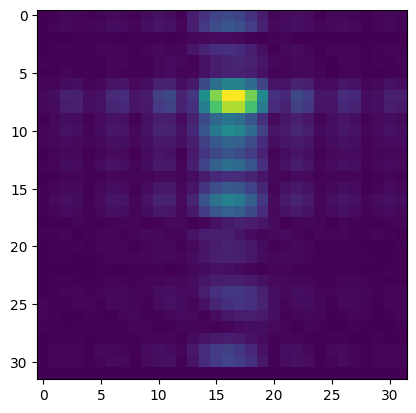

In [ ]:
# show image
path = img_paths_train[100]
with h5py.File(path, 'r') as file:
    img = np.array(file['DS1'][:])
img = img[0, :, :, 0]
print(path)
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
# Extract img class
# os.sep: /
print(path)
print(path.split(os.sep))
cls = path.split(os.sep)[-2]
print(cls)

/content/drive/MyDrive/2024 毫米波/Low/Background_0011_2024_08_18_08_39_21.h5
['', 'content', 'drive', 'MyDrive', '2024 毫米波', 'Low', 'Background_0011_2024_08_18_08_39_21.h5']
Low


In [ ]:
cls_idx = class_map[cls]
cls_idx

1

#### Dataset & DataLoader

In [ ]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, paths, class_map):
        self.paths = paths
        self.class_map = class_map
        self.paths = paths
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        path = self.paths[idx]
        with h5py.File(path, 'r') as file:
            data = np.array(file['DS1'][:])[0, :, :]
        # Normalize
        data = (data - data.min()) / (data.max() - data.min())
        data = torch.tensor(data, dtype=torch.float).unsqueeze(0)
        cls = path.split(os.sep)[-2]
        cls_idx = self.class_map[cls]
        cls_idx = torch.tensor(cls_idx, dtype=torch.long)
        return data, cls_idx

In [ ]:
# Build dataset
h5_paths = sorted(glob('/content/drive/MyDrive/2024 毫米波/*/*.h5'))
train_paths, val_paths = train_test_split(h5_paths,
                                          test_size=0.2,
                                          random_state=5566)
train_ds = VideoDataset(train_paths, class_map)
val_ds = VideoDataset(val_paths, class_map)

In [ ]:
# Number of samples: __len__
len(train_ds), len(val_ds)

(151, 38)

In [ ]:
# __getitem__
img, label = train_ds[0]
print(img.shape, label, all_class[label])

# img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
# plt.imshow(img)
# plt.show()

torch.Size([1, 32, 32, 200]) tensor(3) High


In [ ]:
# Build DataLoaders
BATCH_SIZE = 16
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

In [ ]:
for (x, y) in train_loader:
    print(x.shape, y.shape)
    print(y)
    break

torch.Size([16, 1, 32, 32, 200]) torch.Size([16])
tensor([2, 0, 1, 1, 1, 1, 1, 3, 3, 2, 3, 1, 2, 1, 3, 1])


### Model



In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2), # img_size/2
        )
    def forward(self, x):
        return self.conv(x)

class CNN(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            ConvBlock(1, 32, kernel_size=kernel_size),
            ConvBlock(32, 64, kernel_size=kernel_size),
            ConvBlock(64, 128, kernel_size=kernel_size),
        )
        self.flatten = nn.Sequential(
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 4),
        )

    def forward(self, x):
        x = self.feature_extractor(x) # img to feature maps
        x = self.flatten(x) # feature maps -> feature vectors
        x = self.classifier(x) # classification
        return x

In [8]:
# Build a model and move to GPU device
model = CNN(kernel_size=3).to(device)
# model = torchvision.models.resnet18()
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.fc = nn.Linear(512, 4)
# model = model.to(device)

In [ ]:
print(model)

CNN(
  (feature_extractor): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
# Model summary
summary(model, (1, 32, 32, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 32, 32, 32, 200]             896
       BatchNorm3d-2      [-1, 32, 32, 32, 200]              64
              ReLU-3      [-1, 32, 32, 32, 200]               0
            Conv3d-4      [-1, 32, 32, 32, 200]          27,680
       BatchNorm3d-5      [-1, 32, 32, 32, 200]              64
              ReLU-6      [-1, 32, 32, 32, 200]               0
         MaxPool3d-7      [-1, 32, 16, 16, 100]               0
         ConvBlock-8      [-1, 32, 16, 16, 100]               0
            Conv3d-9      [-1, 64, 16, 16, 100]          55,360
      BatchNorm3d-10      [-1, 64, 16, 16, 100]             128
             ReLU-11      [-1, 64, 16, 16, 100]               0
           Conv3d-12      [-1, 64, 16, 16, 100]         110,656
      BatchNorm3d-13      [-1, 64, 16, 16, 100]             128
             ReLU-14      [-1, 64, 16, 

### Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    # lr=1e-1, # learning rate
)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
EPOCHS = 10
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    # save best
    if val_acc == max(logs['val_acc']):
        torch.save(model.state_dict(), '/content/drive/MyDrive/2024 毫米波/model3D.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 0.7692, train_acc: 0.642     val_loss: 1.5503, val_acc: 0.342 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 0.4878, train_acc: 0.815     val_loss: 5.5080, val_acc: 0.316 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 0.2415, train_acc: 0.954     val_loss: 4.5739, val_acc: 0.316 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.1534, train_acc: 0.974     val_loss: 4.7797, val_acc: 0.316 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.1117, train_acc: 0.980     val_loss: 1.1745, val_acc: 0.605 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.1044, train_acc: 0.967     val_loss: 1.6675, val_acc: 0.553 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.0553, train_acc: 0.987     val_loss: 0.8537, val_acc: 0.526 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.0368, train_acc: 1.000     val_loss: 0.1269, val_acc: 0.974 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.0191, train_acc: 1.000     val_loss: 0.0424, val_acc: 1.000 


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.0247, train_acc: 1.000     val_loss: 0.1607, val_acc: 0.947 


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/2024 毫米波/model3D.pth')

#### Logs

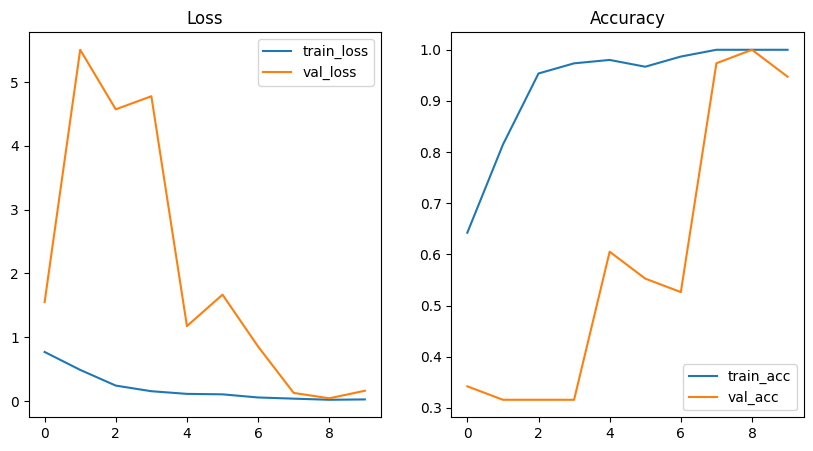

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Evaluation

In [ ]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = torch.nn.functional.softmax(y_pred_logits, dim=1) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()


In [ ]:
# Shape
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

((38,), (38, 4), (38,))

In [ ]:
# calculate ACC.
acc = sum(y_true == y_pred_cls) / len(y_true)
acc

0.9473684210526315

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_cls, target_names=all_class))

              precision    recall  f1-score   support

  Background       1.00      1.00      1.00         4
         Low       1.00      0.86      0.92        14
      Middle       1.00      1.00      1.00        12
        High       0.80      1.00      0.89         8

    accuracy                           0.95        38
   macro avg       0.95      0.96      0.95        38
weighted avg       0.96      0.95      0.95        38



# Inference

In [ ]:
model = CNN(kernel_size=3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/2024 毫米波/model3D.pth'))
_ = model.eval()

In [ ]:
for name in all_class:
    video_paths = glob(f'/content/drive/MyDrive/2024 毫米波/{name}/*.h5')
    # random sample
    video_ds = VideoDataset(video_paths, class_map)
    img, label = video_ds[np.random.randint(len(video_ds))]

    # Inference
    with torch.no_grad():
        img = img.to(device)[:32, :, :]
        img = img.unsqueeze(0)
        pred = model(img)

        pred_cls = pred.argmax(1).item()
        pred_prob = torch.nn.functional.softmax(pred, dim=1)[0, pred_cls]

        print(f'{name:<10}: pred_prob: {pred_prob:.4f}, pred_cls: {int(pred_cls)}, gt_cls: {label}')

Background: pred_prob: 0.9972, pred_cls: 0, gt_cls: 0
Low       : pred_prob: 0.7118, pred_cls: 3, gt_cls: 1
Middle    : pred_prob: 0.9719, pred_cls: 2, gt_cls: 2
High      : pred_prob: 0.9985, pred_cls: 3, gt_cls: 3


#### Test running time

In [18]:
import time
inputs = torch.randn(1, 1, 32, 32, 200).to(device)
# timer start
start = time.time()
with torch.no_grad():
    outputs = model(inputs)
end = time.time()
print(f'Inference time: {end - start:.4f}s')

Inference time: 0.0042s
